# Toronto Neighborhood Clusters
Week 3 assignment of IBM Data Science Professinal Certificate Capstone. In this notebook I use Foursquare data to find similar clusters of neighborhoods in Toronto. I scrape Wikipedia page to get all Postal Codes, Boroughs and Neighborhoods and create a Foursquare API to extract nearby venues that are used to compare neighborhoods. I find the optimal number of clusters before grouping each neighborhood into clusters using KNN and finish with creating a map using Folium.

All three parts are located in this one notebook. Please find links to the various parts below:

[Part 1: Create neighborhood dataframe](#part1)<br>
[Part 2: Combine geospatial data](#part2)<br>
[Part 3: Cluster analysis](#part3)

<a class="anchor" id='part1'></a>
## Part 1: Create Neighborhood dataframe

### Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.18.1               |             py_0          51 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          84 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0     conda-forge

The following packages will be UPDATED:

    geopy:         1.11.0-py36_0 conda-forge --> 1.18.1-py_0 conda-forge


geopy-1.18.1         | 51 KB     | ##################################### | 100% 
geographiclib-1.49   | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executi

### Create Postal Code Dataframe

Select Wikipedia page, create BeautifulSoup object and transform into Pandas dataframe.

In [2]:
#import library to parse HTML from page
from bs4 import BeautifulSoup

In [3]:
# Select page
wiki = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

# Save page as text object
soup = BeautifulSoup(wiki, 'lxml')
#print(soup.prettify())

In [4]:
#find table information in Wiki page
table = soup.find('table',{'class':'wikitable sortable'})

#creating lists for each of the columns I know to be in my table.
A=[]
B=[]
C=[]

#append lists into one dataframe
for row in table.findAll('tr'):
    cells = row.findAll('td')
    if len(cells)==3: #Only extract table body not heading
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))
        

df=pd.DataFrame(A,columns=['PostalCode'])
df['Borough']=B
df['Neighborhood']=C

#make PostalCode the index
df.set_index('PostalCode')

df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


### Remove unassigned Boroughs

In [5]:
#create a dataframe without borough that are not assigned
df = df[df.Borough != 'Not assigned']

In [6]:
#strip whitespace from dataframe
df['Neighborhood'] = df['Neighborhood'].str.strip()
df[0:9]

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Not assigned
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge


### Find unassigned neighborhoods and replace with Borough name

In [7]:
#create list of not assigned neighborhoods
array = ['Not assigned']
df.loc[df['Neighborhood'].isin(array)]

,PostalCode,Borough,Neighborhood
8,M7A,Queen's Park,Not assigned


In [8]:
#Rename neighborhood
df.loc[8, 'Neighborhood'] = "Queen's Park"
df[0:9]

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M5A,Downtown Toronto,Regent Park
6,M6A,North York,Lawrence Heights
7,M6A,North York,Lawrence Manor
8,M7A,Queen's Park,Queen's Park
10,M9A,Etobicoke,Islington Avenue
11,M1B,Scarborough,Rouge


### Combine neighborhoods into one row per Postal Code

In [9]:
#Group all neighborhoods by postal code and borough, separated by comma
df2 = df.groupby(['PostalCode','Borough'], as_index = False).agg(lambda x: ', '.join(x))
df2.reset_index()
df2.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


### Find number of rows in dataframe

In [10]:
df2.shape

(103, 3)

<a class="anchor" id='part2'></a>
## Part 2: Combine with geospatial data

### Download geospatial data

In [11]:
!wget -O geo_data.csv https://cocl.us/Geospatial_data

--2019-01-22 15:43:24--  https://cocl.us/Geospatial_data
Resolving cocl.us (cocl.us)... 169.48.113.201
Connecting to cocl.us (cocl.us)|169.48.113.201|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-01-22 15:43:24--  https://ibm.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.box.com (ibm.box.com)... 107.152.26.197, 107.152.27.197
Connecting to ibm.box.com (ibm.box.com)|107.152.26.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ibm.ent.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv [following]
--2019-01-22 15:43:25--  https://ibm.ent.box.com/shared/static/9afzr83pps4pwf2smjjcf1y5mvgb18rr.csv
Resolving ibm.ent.box.com (ibm.ent.box.com)... 107.152.24.211, 107.152.25.211
Connecting to ibm.ent.box.com (ibm.ent.box.com)|107.152.24.211|:443... connected.
HTTP request sent

In [12]:
geo_df = pd.read_csv('geo_data.csv')
geo_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


### Merge geospatial data with neighborhood dataframe

In [13]:
#merge and clean two dataframes
final_df = df2.merge(geo_df, left_on='PostalCode', right_on='Postal Code', how='outer')
final_df = final_df.drop('Postal Code', axis =1)
final_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


### Isolate Toronto neighborhood data
I am going to focus on boroughs with 'Toronto' in the title, so I need to isolate those boroughs.

In [14]:
#create alist of all unique boroughs
final_df.Borough.unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [15]:
#select boroughs with 'Toronto' in their name
toronto_array = ['East Toronto', 'Central Toronto', 'Downtown Toronto', 'West Toronto']
toronto_df = final_df.loc[final_df['Borough'].isin(toronto_array)]
toronto_df = toronto_df.reset_index(drop=True)
toronto_df[0:5]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [16]:
#describe the final dataset
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_df['Borough'].unique()),
        (pd.Series(toronto_df.Neighborhood.str.cat(sep=', ').split(', ')).nunique())
    )
)

The dataframe has 4 boroughs and 73 neighborhoods.


<a class="anchor" id='part3'></a>
## Part 3: Cluster analysis

### Create initial map

In [17]:
#find geo coordinates of Toronto
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.653963, -79.387207.


In [18]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add neighborhood markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Connect to Foursquare API

In [19]:
CLIENT_ID = 'I0CN3Q0K0RZ0JZBXCRN1U2ADYMRNPN2OPNBCXNNCJJRC3GKK' # your Foursquare ID
CLIENT_SECRET = 'DZGUDE2CQPNUHO0MJKEQNUT1B4TQC5JIDWTVGT5QGT2WWJFJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: I0CN3Q0K0RZ0JZBXCRN1U2ADYMRNPN2OPNBCXNNCJJRC3GKK
CLIENT_SECRET:DZGUDE2CQPNUHO0MJKEQNUT1B4TQC5JIDWTVGT5QGT2WWJFJ


### Get Latitude and longitude for one neighborhood

In [20]:
#select the first neighborhood in dataframe
toronto_df.loc[0, 'Neighborhood']

'The Beaches'

In [21]:
#get the latitude and longitude for the first neighborhood in dataframe
neighborhood_latitude = toronto_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_df.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


### Create API URL

In [22]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=I0CN3Q0K0RZ0JZBXCRN1U2ADYMRNPN2OPNBCXNNCJJRC3GKK&client_secret=DZGUDE2CQPNUHO0MJKEQNUT1B4TQC5JIDWTVGT5QGT2WWJFJ&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [23]:
#create json of Foursquare results
results = requests.get(url).json()
#results

In [24]:
#extract category of venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [25]:
#create dataframe of venues
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

# View resulting dataframe
nearby_venues.head()

,name,categories,lat,lng
0,Grover Pub and Grub,Pub,43.679181,-79.297215
1,Starbucks,Coffee Shop,43.678798,-79.298045
2,Upper Beaches,Neighborhood,43.680563,-79.292869
3,Dip 'n Sip,Coffee Shop,43.678897,-79.297745


In [26]:
#see how many venues were returned
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


In [27]:
#function to extract venues from entire neighborhood dataframe
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [29]:
print(toronto_venues.shape)
toronto_venues.head()

(1706, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
1,The Beaches,43.676357,-79.293031,Starbucks,43.678798,-79.298045,Coffee Shop
2,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
3,The Beaches,43.676357,-79.293031,Dip 'n Sip,43.678897,-79.297745,Coffee Shop
4,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [30]:
#count values in each neighborhood - make sure they match
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,54,54,54,54,54,54
"Brockton, Exhibition Place, Parkdale Village",19,19,19,19,19,19
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",14,14,14,14,14,14
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,81,81,81,81,81,81
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,15,15,15,15,15,15


In [31]:
#count the number of unique venue categories
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 239 uniques categories.


### One hot encoding
One hot encoding allows us to use K means clustering

In [32]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

#toronto_onehot.head()

In [33]:
#view the mean of frequency of occurance for each venue category in each neighborhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Piano Bar,Pizza Place,Plane,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store
0,"Adelaide, King, Richmond",0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.04,0.0,0.0,0.0,0.010000,0.01,0.0,0.03,0.000000,0.0,0.0,0.000000,0.030000,0.0,0.030000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.02,0.000000,0.01,0.020000,0.000000,0.0,0.01,0.02,0.010000,0.0,0.0,0.050000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.030000,0.010000,0.060000,0.0,0.0,0.0,0.000000,0.000000,0.020000,0.000000,0.020000,0.0,0.000000,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.000000,0.000000,0.

In [34]:
#view number of categories and neighborhoods
toronto_grouped.shape

(38, 239)

### Find the top 5 categories in each neighborhood

In [35]:
#set the top frequency of venues to see for each neighborhood
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.06
1                 Café  0.05
2           Steakhouse  0.04
3      Thai Restaurant  0.04
4  American Restaurant  0.04


----Berczy Park----
            venue  freq
0     Coffee Shop  0.07
1      Restaurant  0.06
2    Cocktail Bar  0.06
3          Bakery  0.04
4  Farmers Market  0.04


----Brockton, Exhibition Place, Parkdale Village----
            venue  freq
0  Breakfast Spot  0.11
1            Café  0.11
2     Coffee Shop  0.11
3    Climbing Gym  0.05
4             Bar  0.05


----Business Reply Mail Processing Centre 969 Eastern----
           venue  freq
0    Yoga Studio  0.06
1  Burrito Place  0.06
2  Garden Center  0.06
3         Garden  0.06
4            Spa  0.06


----CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara----
              venue  freq
0    Airport Lounge  0.14
1   Airport Service  0.14
2  Airport Terminal  0.14
3  Sculpt

### Find the most popular venue category rankings in each neighborhood

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,American Restaurant,Thai Restaurant,Restaurant,Asian Restaurant,Bakery,Bar,Clothing Store
1,Berczy Park,Coffee Shop,Restaurant,Cocktail Bar,Café,Farmers Market,Steakhouse,Pub,Seafood Restaurant,Bakery,Cheese Shop
2,"Brockton, Exhibition Place, Parkdale Village",Coffee Shop,Café,Breakfast Spot,Bar,Stadium,Burrito Place,Italian Restaurant,Climbing Gym,Office,Furniture / Home Store
3,Business Reply Mail Processing Centre 969 Eastern,Yoga Studio,Auto Workshop,Park,Pizza Place,Moving Target,Recording Studio,Restaurant,Burrito Place,Brewery,Skate Park
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Lounge,Airport Service,Airport Terminal,Plane,Boutique,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boat or Ferry


### KNN analysis

In [38]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [39]:
#create new dataframe of merged data
toronto_merged = toronto_df

# add clustering labels
toronto_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

# make sure the dataframe is correct
toronto_merged.head() 

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Coffee Shop,Pub,Women's Store,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,0,Park,Pizza Place,Pub,Fast Food Restaurant,Board Shop,Liquor Store,Fish & Chips Shop,Burger Joint,Sandwich Place,Burrito Place
3,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Sandwich Place,Cheese Shop
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,0,Bus Line,Park,Dim Sum Restaurant,Swim School,Women's Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


### Find the optimal number of clusters

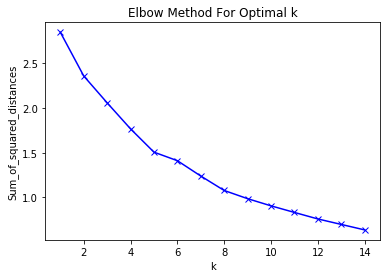

In [48]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(toronto_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

It does look like 5 clusters is the optimal number based on the elbow method so we can continue our analysis.

### Create cluster map

In [49]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## View all clusters

### View cluster 1

In [51]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,East Toronto,0,Coffee Shop,Pub,Women's Store,Discount Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
1,East Toronto,0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Bookstore,Italian Restaurant,Yoga Studio,Cosmetics Shop,Brewery,Bubble Tea Shop,Restaurant
2,East Toronto,0,Park,Pizza Place,Pub,Fast Food Restaurant,Board Shop,Liquor Store,Fish & Chips Shop,Burger Joint,Sandwich Place,Burrito Place
3,East Toronto,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Yoga Studio,Coworking Space,Seafood Restaurant,Sandwich Place,Cheese Shop
4,Central Toronto,0,Bus Line,Park,Dim Sum Restaurant,Swim School,Women's Store,Filipino Restaurant,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space
5,Central Toronto,0,Park,Breakfast Spot,Burger Joint,Food & Drink Shop,Dance Studio,Clothing Store,Sandwich Place,Hotel,Grocery Store,Gym
6,Central Toronto,0,Sporting Goods Shop,Coffee Shop,Clothing Store,Salon / Barbershop,Sandwich Place,Diner,Rental Car Location,Furniture / Home Store,Dessert Shop,Chinese Restaurant
7,Central Toronto,0,Pizza Place,Dessert Shop,Sandwich Place,Italian Restaurant,Seafood Restaurant,Café,Sushi Restaurant,Coffee Shop,Chinese Restaurant,Diner
8,Central Toronto,0,Playground,Gym,Tennis Court,Park,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Diner,Electronics Store
9,Central Toronto,0,Pub,Coffee Shop,American Restaurant,Light Rail Station,Sushi Restaurant,Bagel Shop,Sports Bar,Supermarket,Fried Chicken Joint,Pizza Place


In [52]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
24,Central Toronto,1,Coffee Shop,Café,Sandwich Place,Pizza Place,History Museum,Indian Restaurant,Pharmacy,Cosmetics Shop,Pub,Burger Joint
27,Downtown Toronto,1,Airport Lounge,Airport Service,Airport Terminal,Plane,Boutique,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Boat or Ferry


In [53]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,West Toronto,2,Breakfast Spot,Gift Shop,Dessert Shop,Burger Joint,Bank,Restaurant,Bookstore,Dog Run,Italian Restaurant,Bar


In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Downtown Toronto,3,Coffee Shop,Restaurant,Café,Italian Restaurant,Beer Bar,Seafood Restaurant,Pub,Hotel,Cocktail Bar,Bakery


In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Central Toronto,4,Pool,Music Venue,Garden,Women's Store,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
